## **Aplicação de Random Forest Regression**
Neste notebook será aplicado o modelo Random Forest Regression utilizando as features extraídas dos dados .
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos modelos benchmark **SARIMA**, **ETS** e **Regressão Linear**. 

In [31]:
# confirgurando diretório
import sys
import os
sys.path.append(os.path.abspath('..'))

# importando bibliotecas
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from src.features import add_trend
from src.evaluation import Evaluation
from src.plots import plot_time_series

# configurando notebook
tqdm.pandas()
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

plt.rcParams["figure.dpi"] = 150

%load_ext autoreload
%autoreload 2

EVAL_PATH = '../data/evaluation.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **Leitura dos Dados**

In [2]:
# leitura dos dados
train_df = pd.read_csv("../data/features_train_df.csv", parse_dates=['ds'], index_col=[0])
test_df = pd.read_csv("../data/features_test_df.csv", parse_dates=['ds'], index_col=[0])

In [3]:
import json

with open("../data/features.json", "r", encoding="utf-8") as arquivo:
    selected_features = json.load(arquivo)

## **Random Forest Regression**

In [4]:
best_models = {}

params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 7, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

In [5]:
def grid_search(estimator, X, y):
    splitter = TimeSeriesSplit(n_splits=3)
    search = GridSearchCV(
        cv=splitter,
        estimator=estimator,
        param_grid=params,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
    )
    search.fit(X, y)
    return search.best_params_


def random_forest(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo RandomForest.
    """    
    train = df.copy().reset_index(drop=True)
    fcst_df = test_df.query("unique_id == @train.unique_id[0]").reset_index(drop=True)

    train, fcst_df = add_trend(train, fcst_df)
    
    features = selected_features[train.unique_id[0]]
    best_model = grid_search(
        estimator=RandomForestRegressor(random_state=1001),
        X=train[features], 
        y=train.y
    )
    best_models[train.unique_id[0]] = best_model
    
    # best model fit_predict
    m = RandomForestRegressor(**best_model, random_state=1001)
    m.fit(X=train[features], y=train.y)
    fcst_df['y_pred'] = m.predict(fcst_df[features])

    return fcst_df

In [6]:
# aplicando modelo para cada série
rf_fcst = train_df.groupby("unique_id")\
    .progress_apply(random_forest)\
    .reset_index(drop=True)

100%|██████████| 14/14 [31:24<00:00, 134.62s/it]


In [ ]:
with open("../data/random_forest_best_model.json", "w", encoding="utf-8") as arquivo:
    json.dump(best_models, arquivo, ensure_ascii=False, indent=4)

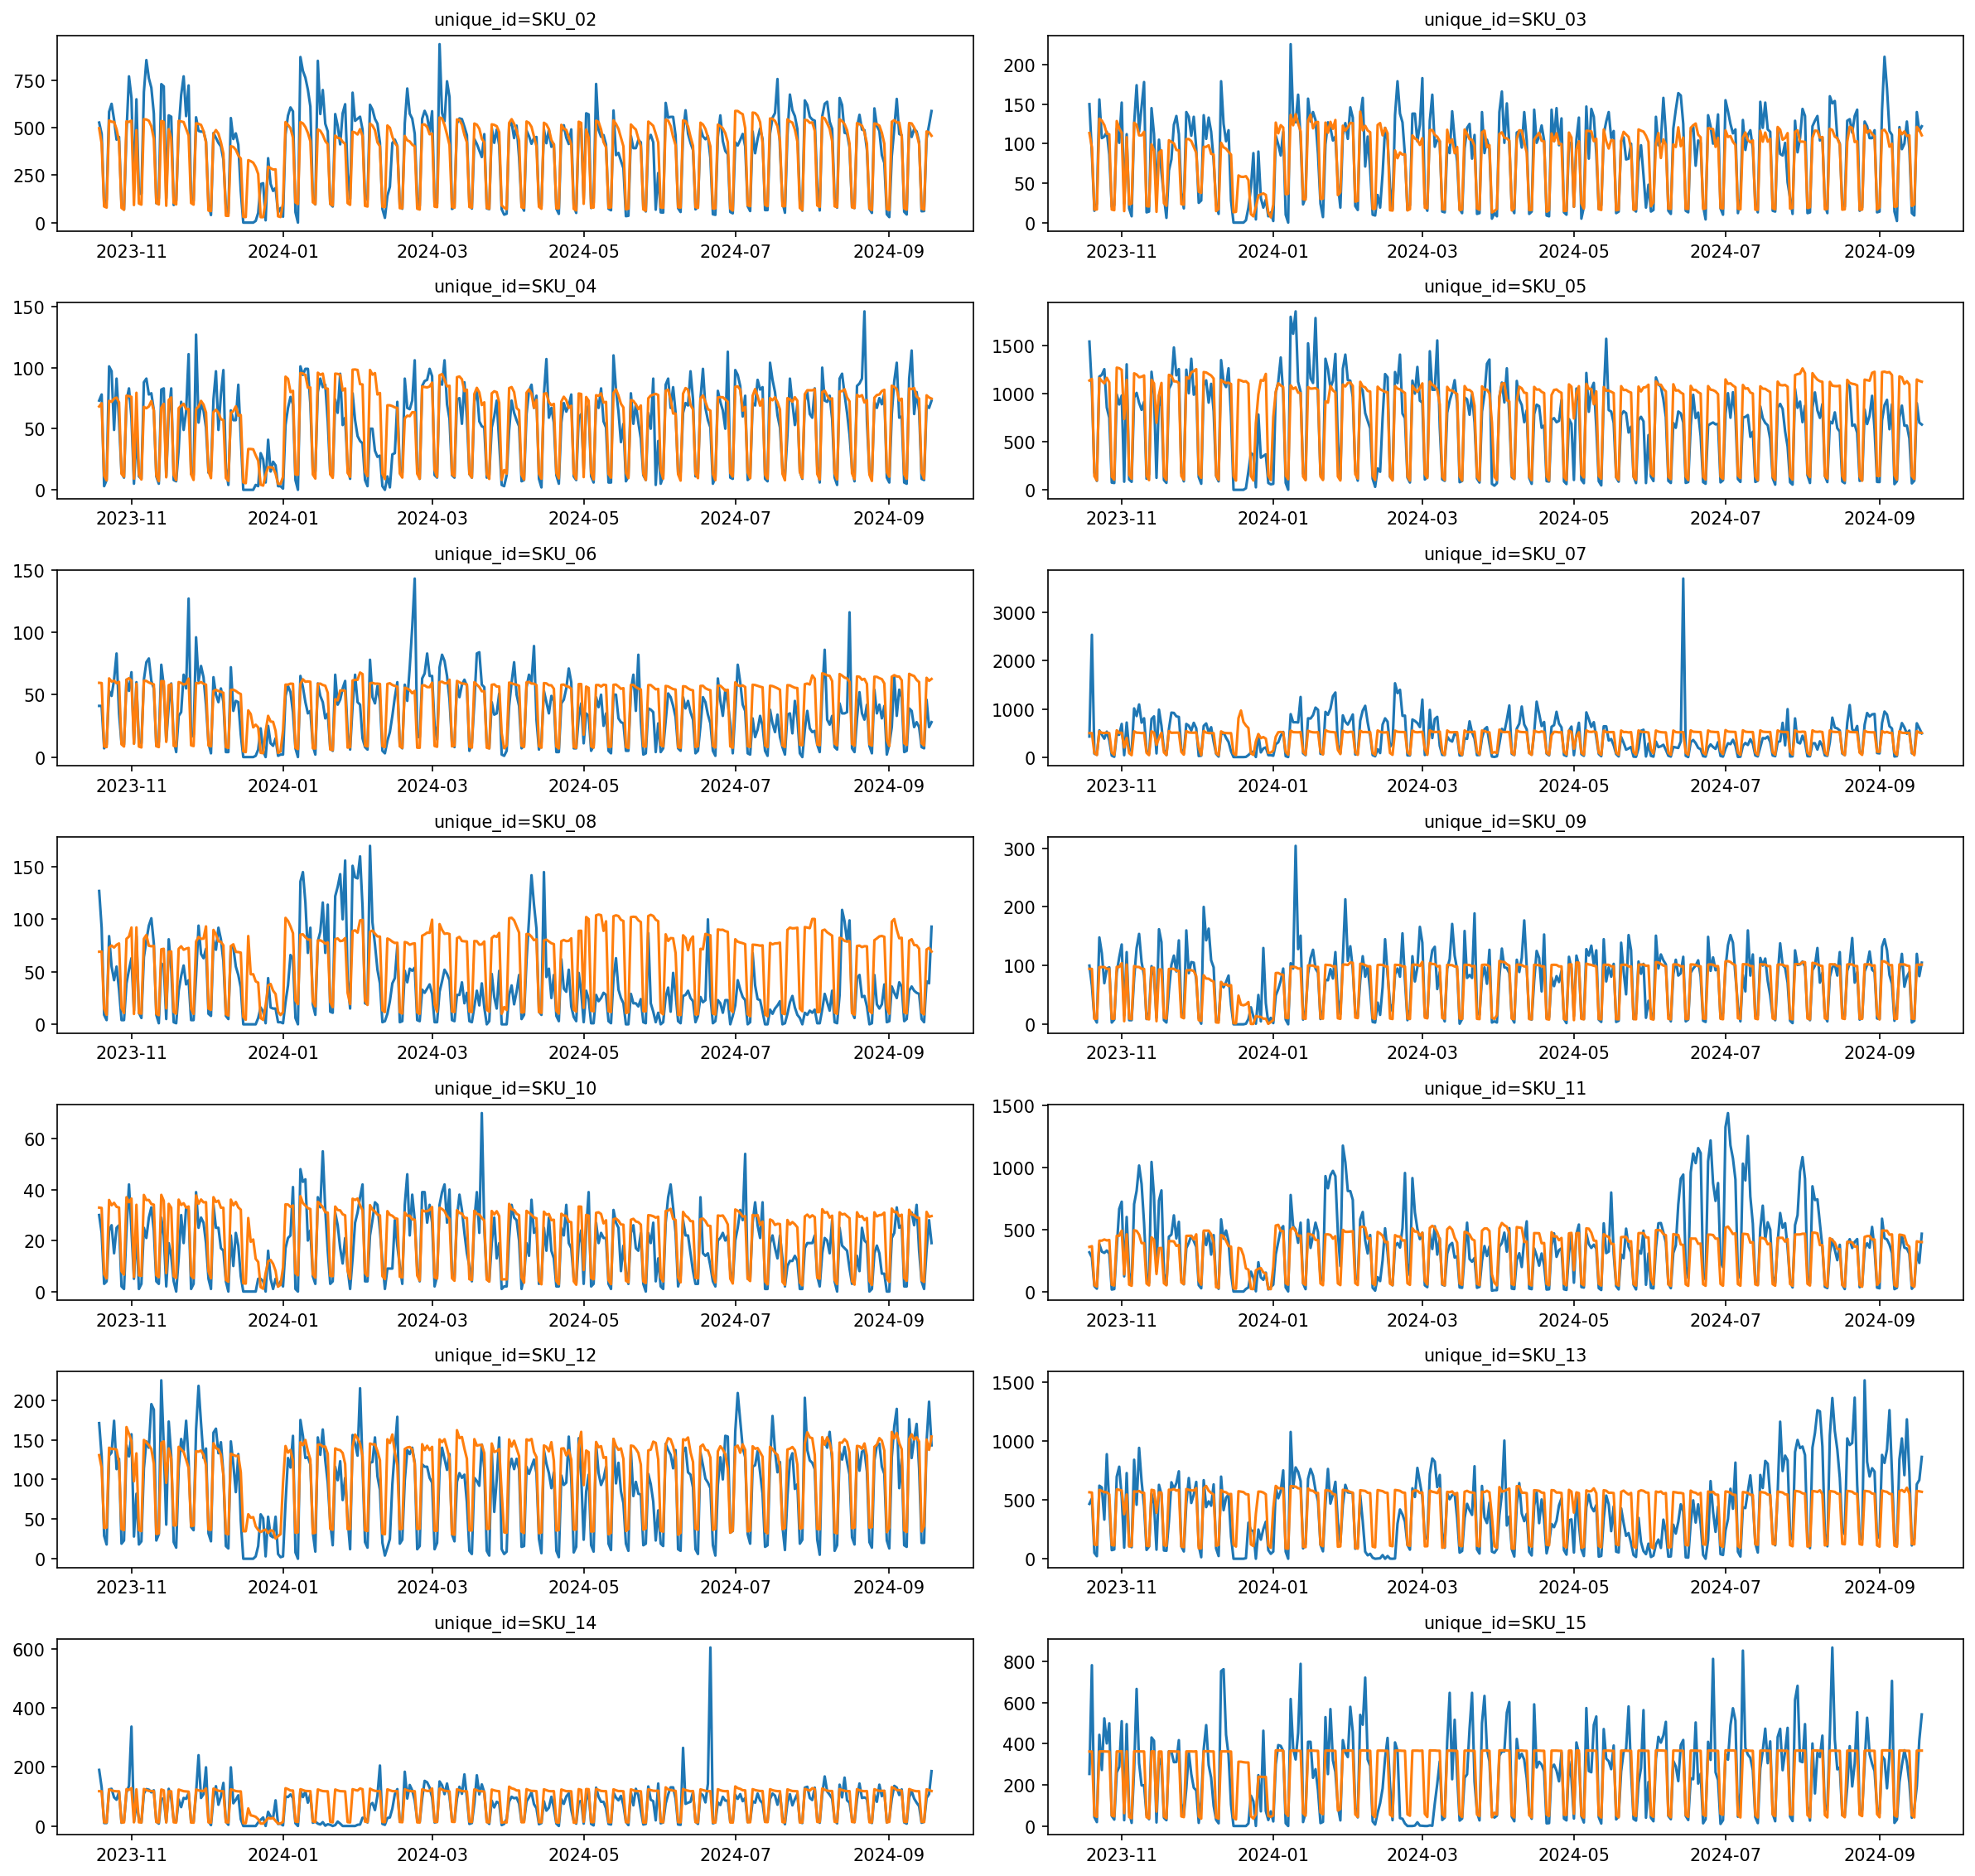

In [7]:
fig = plot_time_series(
    df=rf_fcst, 
    figsize=(16, 16),
    data_cols=['y', 'y_pred'], 
)

In [13]:
rf_eval = Evaluation(rf_fcst)
rf_eval.summary()
rf_eval.save_evaluation(EVAL_PATH, 'Random Forest')
rf_eval.evaluation_df

,mae,mse,rmse,r2
SKU_02,72.49,11325.23,106.42,0.78
SKU_03,19.64,751.04,27.41,0.73
SKU_04,12.84,347.60,18.64,0.69
SKU_05,223.80,98107.91,313.22,0.50
SKU_06,14.20,366.96,19.16,0.42
SKU_07,205.58,110946.65,333.09,0.32
SKU_08,34.01,1825.26,42.72,-0.41
SKU_09,18.91,854.41,29.23,0.68
SKU_10,7.59,96.96,9.85,0.40
SKU_11,147.00,51829.30,227.66,0.44


In [ ]:
# SKU_02 
# SKU_04
# SKU_09
# SKU_12

In [38]:
# comparação dos modelos
metrics = pd.read_csv(EVAL_PATH)
order = metrics['model'].unique()
metrics = metrics.pivot_table('r2','unique_id','model')[order]
metrics.sort_values('Random Forest', ascending=False)
# metrics[metrics['Random Forest'] > metrics['XGBoost']].sort_values('Random Forest', ascending=False)

model,Naive Sazonal,SARIMA,ETS,Decision Tree,XGBoost,Random Forest
unique_id,,,,,,
SKU_02,0.090,0.643,0.647,0.565,0.748,0.779
SKU_03,-0.037,0.625,0.628,0.526,0.741,0.735
SKU_04,0.211,0.504,0.577,0.453,0.677,0.688
SKU_09,-0.052,0.001,0.531,0.441,0.647,0.679
SKU_12,-0.253,0.508,0.549,0.333,0.637,0.665
SKU_05,-0.454,0.458,0.347,0.571,0.671,0.504
SKU_15,-0.959,-0.025,0.425,0.168,0.492,0.499
SKU_11,-0.079,0.385,0.261,0.203,0.462,0.442
SKU_06,0.082,0.268,0.376,0.210,0.349,0.415
